# Question 1
"Natural images present a simple and intuitive example of this inherent compressibility. A grayscale image may be thought of as a real-valued matrix X ∈ Rn×m, where n and m are the number of pixels in the vertical and horizontal direction, respectively. Depending on the basis of representation images may have very compact approximations. Capture a selfie without a rich background (to make it easier just take a picture of you in front of a wall), convert RBG to gray (256 bit to double) and compress the image using SVD. Plot several different images using different ranks, and examine how the resolution changes. Make sure to comment what rank is sufficient to store the image (identify an elbow point if possible). What do you observe?"

In [1]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from IPython.display import Image

My selfie can be seen here:

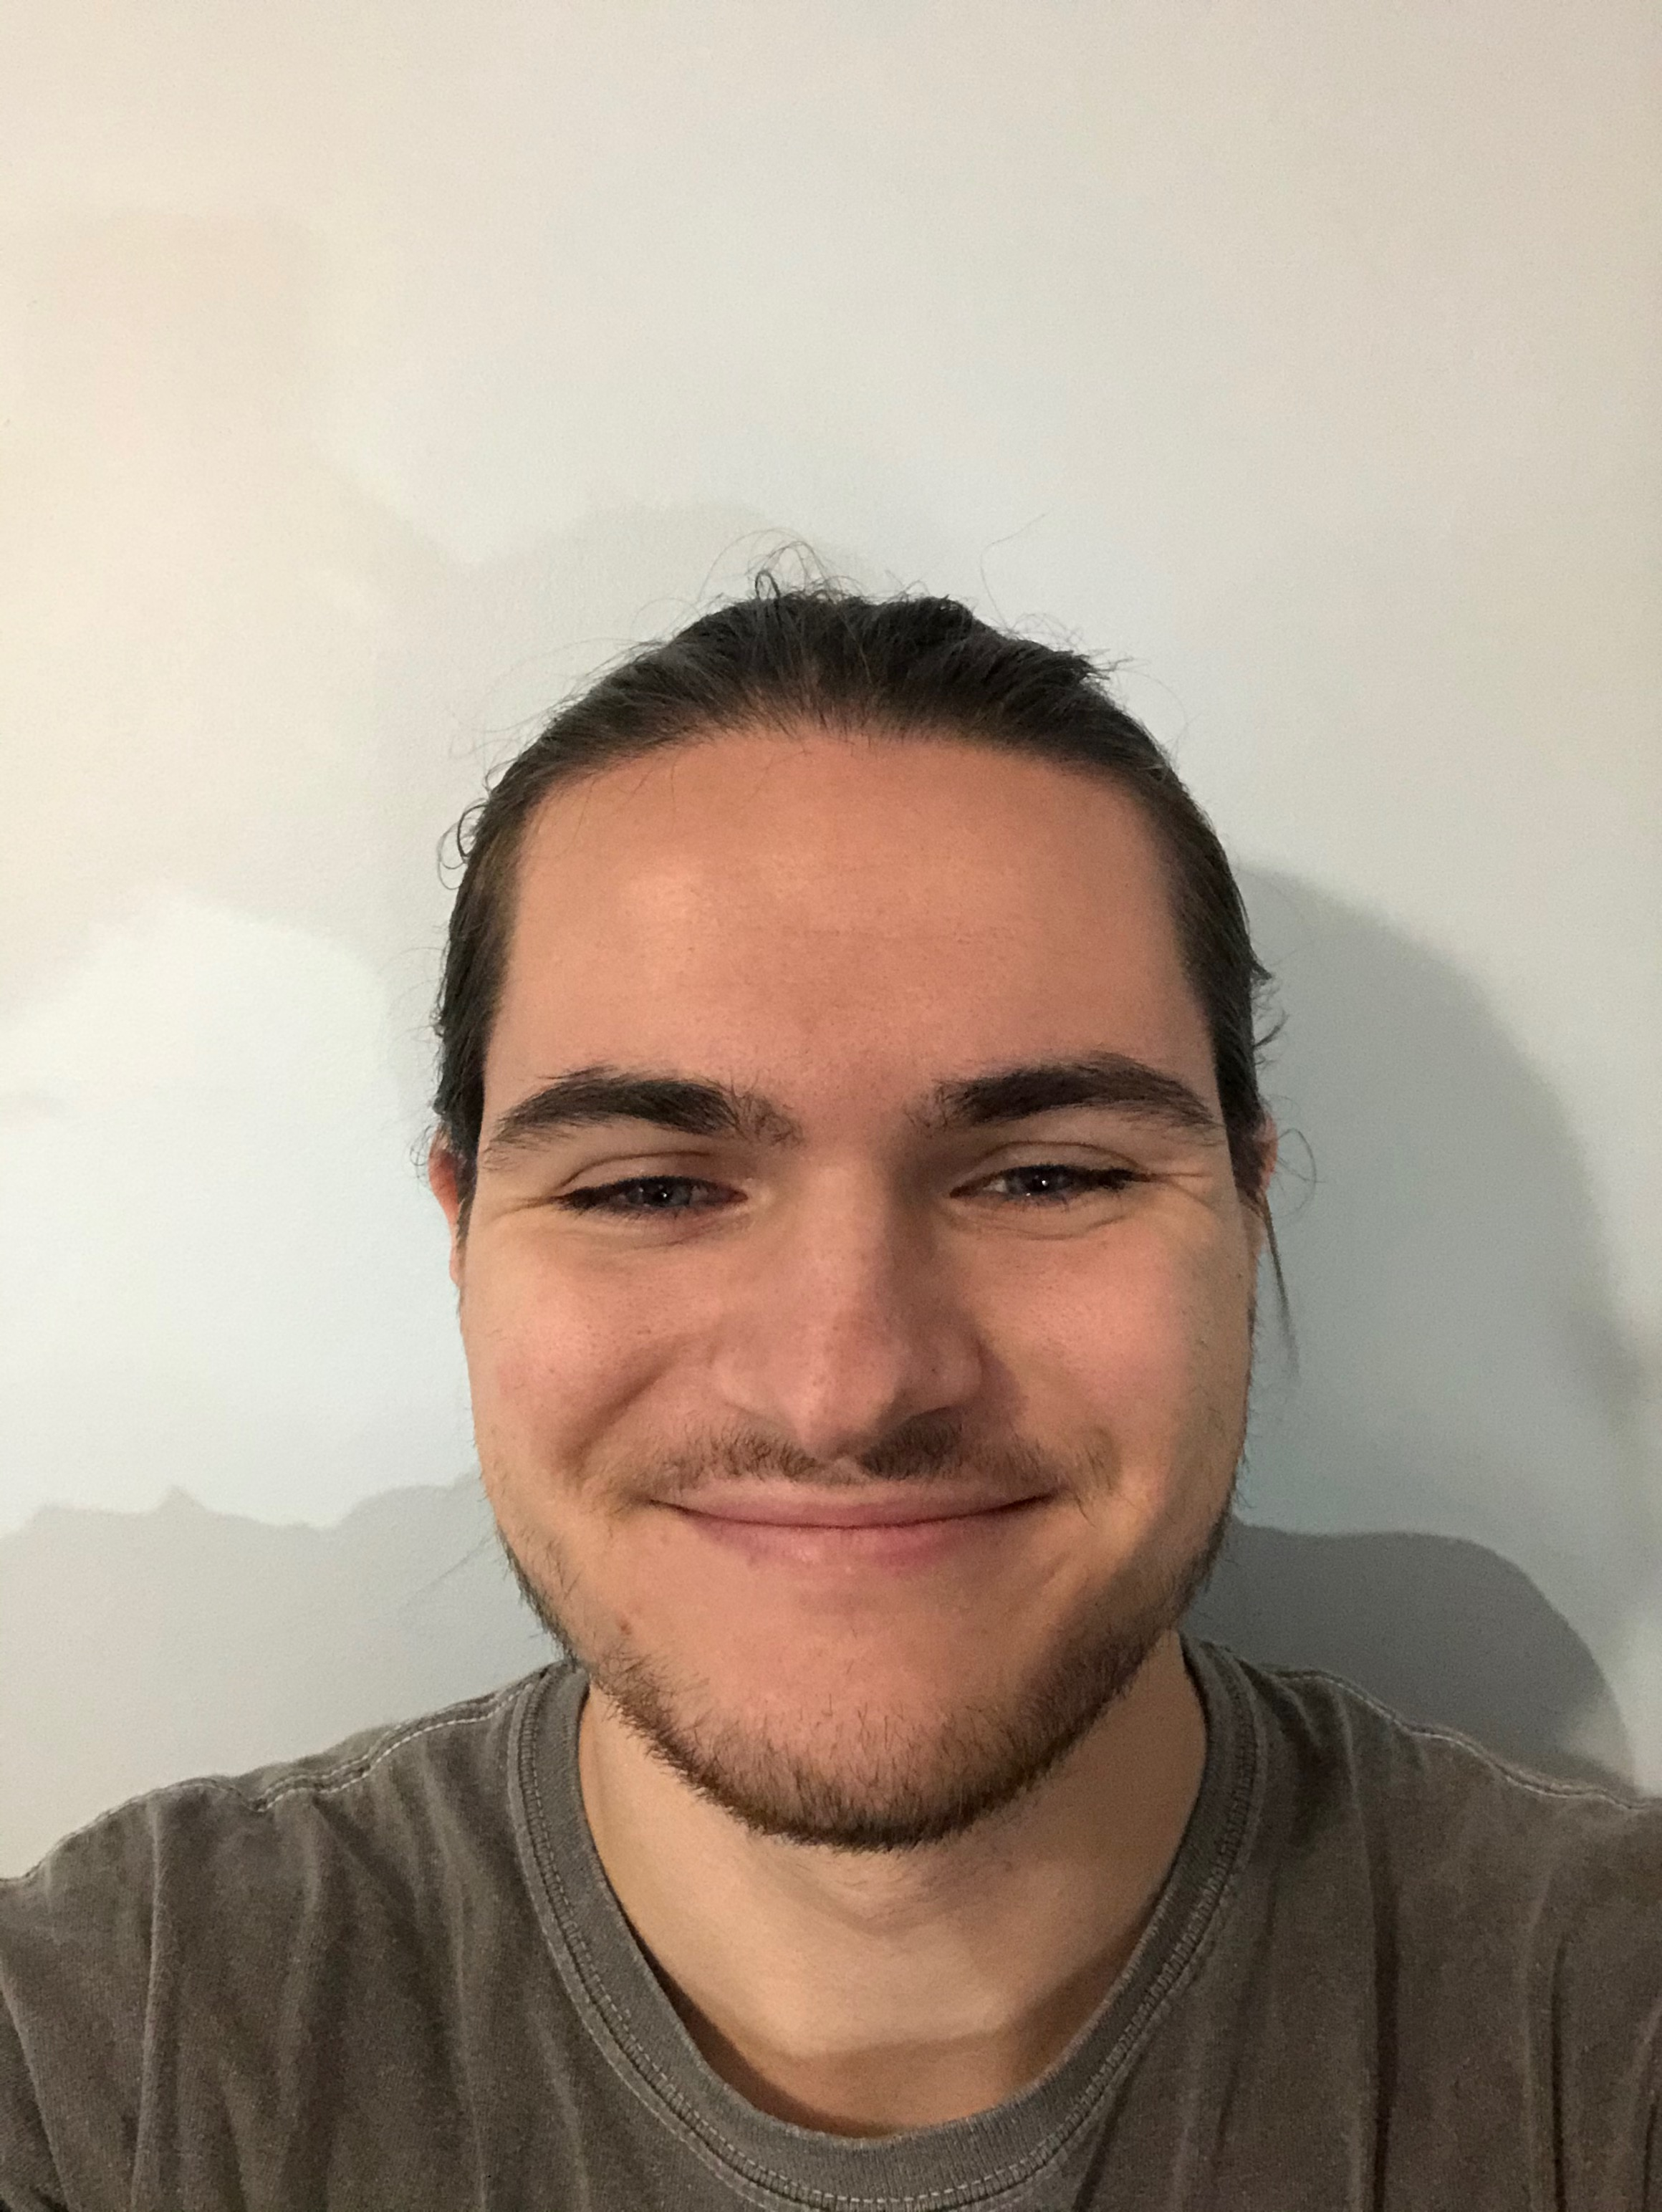

In [2]:
Image(filename = os.path.join(os.getcwd(), "selfie.jpeg"))

## Loading the Image
First I'll load the image by using Tensorflow's image processing tools. The original image is a jpeg. In this block of code, I convert the RGB image into a grayscale image.

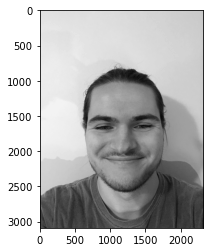

In [3]:
def load_image():
    read_f = tf.io.read_file("selfie.jpeg")
    img = tf.image.decode_jpeg(read_f, channels = 1)
    np_img = np.array(img).reshape(list(img.shape)[0:2])
    return np_img

selfie = load_image()
plt.imshow(selfie, cmap = "gray")
plt.show()

## SVD Method to Decompose Matrices

The SVD is a matrix decomposition method. For any $m x n$ matrix $A$, we can simplify it to:

$$A = U\Sigma V^T$$

To find each of these matrices, we follow the following steps:

1. $\Sigma$

$\Sigma$ is constructed of each of the singular values $\sigma_i$. First, we must compute the eigenvalues of the covariance matrix $S$:

$$S = A^TA$$

Then the singular values are computed by taking:

$$\sigma_i = \sqrt{\lambda_i}$$

Where $\lambda_i$'s are the eigenvalues of the covariance matrix $S$.

However, each $\sigma$ must be ordered such that the list: $\sigma_1, \sigma_2, ..., \sigma_n$ follows the inequality:

$$\sigma_1 \geq \sigma_2 \geq ... \geq \sigma_n$$

Then, 

$$\Sigma = \begin{bmatrix}
            \sigma_1 & 0 & \cdots & 0 & \cdots & 0\\
            0 & \sigma_2 & \cdots & 0 & \cdots & 0\\
            \vdots & \vdots & \ddots & \cdots  & \cdots & 0\\
            0 & 0 & \cdots & \sigma_n &\cdots & 0\\
            0 & 0 & \cdots & 0 &\cdots & 0\\
            \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
            0 & 0 & 0 & 0 & 0 & 0 \\
            \end{bmatrix}$$
            
One hyperparameter to the algorithm is an $r$ value, where this restricts the number of singular values used to construct $\Sigma$. The new list becomes:

$$\sigma_1 \geq \sigma_2 \geq ... \geq \sigma_r$$

Where $r \leq n$. Therefore, the reduced $\Sigma$ matrix is:

$$\Sigma = \begin{bmatrix}
            \sigma_1 & 0 & \cdots & 0 & \cdots & 0\\
            0 & \sigma_2 & \cdots & 0 & \cdots & 0\\
            \vdots & \vdots & \ddots & \cdots  & \cdots & 0\\
            0 & 0 & \cdots & \sigma_r &\cdots & 0\\
            0 & 0 & \cdots & 0 &\cdots & 0\\
            \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
            0 & 0 & 0 & 0 & 0 & 0 \\
            \end{bmatrix}$$
            
            
2. $V$

This matrix is made up of each of the corresponding eigenvectors $v_i$ for each $\lambda_i$ (with $\lambda_i$'s being sorted in descending order). These eigenvectors must be normalized, and they must be sorted in order of their corresponding eigenvalue. Each of these eigenvectors must be initially aligned in columns, i.e.:

$$V = \Big[ v_1 v_2 \cdot v_n\Big]$$

Or with the reduced SVD:

$$V = \Big[ v_1 v_2 \cdot v_r\Big]$$

For the final calculation, we then take the transpose of $V$ ($V^T$).

3. $U$

Each row of $U$ is calculated by the following formula:

$$u_i = \frac{Av_i}{\sigma_i}$$

Where $\sigma_i$ is the singular value corresponding to $v_i$, the eigenvector. Therefore, we have:

$$U = \begin{bmatrix}
        u_1 \\
        \vdots \\
        u_n
        \end{bmatrix}$$

Or with the reduced SVD:

$$U = \begin{bmatrix}
        u_1 \\
        \vdots \\
        u_r
        \end{bmatrix}$$

## SVD Function
For this problem, I decided to write my own SVD function. The steps for this function are layed out in the comments. 

In [4]:
def compute_SVD(A, rank = -1):

    # 1. Take A^T*A
    ATA = np.matmul(A.T, A)

    # 2. Get eigenvalues of A^T*A
    evals, evecs = np.linalg.eig(ATA)
    #   Note: numpy's implementation automatically normalizes eigenvectors

    if (rank == -1):
        rank = len(evals)
    
    # 2a. Sort the eigenvalues/eigenvectors by eigenvalue order
    sort_inds = np.flip(np.argsort(evals))
    evecsT = evecs.T
    evec_s = np.array([evecsT[i] for i in sort_inds[0:rank]]).T
    eval_s = np.array([evals[i] for i in sort_inds[0:rank]])

    # 3. Compute square roots of eigenvalues 
    sing_vals = [np.sqrt(abs(ev)) for ev in eval_s]
    Sigma = np.zeros((len(sing_vals), len(sing_vals)))
    for s in range(len(sing_vals)): # Loading SV's into 2x2 matrix
        Sigma[s][s] = sing_vals[s]

    # 4. Make the V matrix:
    VT = evec_s.T

    # 5. Compute U matrix
    U = np.array([(1 / sing_vals[i]) * np.matmul(A, evec_s[:,i]) for i in range(0, rank)]).T

    # Error rate is sum of eigenvalues we omitted / total sum of eigenvalues
    error_rate = (sum(sing_vals) / sum([np.sqrt(abs(ev)) for ev in evals]))

    return ((U @ Sigma @ VT), error_rate)

## Image vs. Error
To test this function, I wrote a routine to test the error rate of the SVD for numbers of singular values kept (`rank` parameter). This code is shown below:

Curr rank =  150
Curr rank =  300
Curr rank =  450
Curr rank =  600
Curr rank =  750
Curr rank =  900
Curr rank =  1050
Curr rank =  1200
Curr rank =  1350
Curr rank =  1500
Curr rank =  1650
Curr rank =  1800
Curr rank =  1950
Curr rank =  2100
Curr rank =  2250


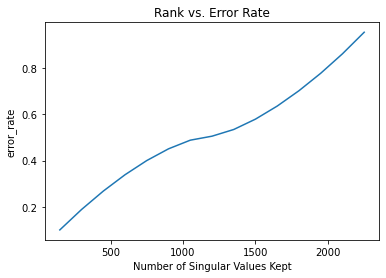

In [5]:
# Run multiple ranks to visualize elbow point
#ranks_to_take = [5, 10, 50, 100, 200, 500, 1000, 1500, 2000, 2250]
ranks_to_take = np.arange(0, 2251, 150)[1:]
e_rates = []
for rank in ranks_to_take:
    print("Curr rank = ", rank) # Prints to keep track of process
    svd_img, e_rate = compute_SVD(selfie, rank)
    e_rates.append(e_rate)

plt.plot(ranks_to_take, e_rates)
plt.xlabel("Number of Singular Values Kept")
plt.ylabel("error_rate")
plt.title("Rank vs. Error Rate")
plt.show()

## SVD's Meaning for Images
As can be seen in the steps above, we can treat our image like a 2D matrix (when taken as grayscale). Therefore, SVD serves to identify the most significant axes of this image, preserving the maximum amount of original variance as compared to other reduction techniques. Therefore, we observe the images reduced with SVD to be close to that of the original, as can be seen below:

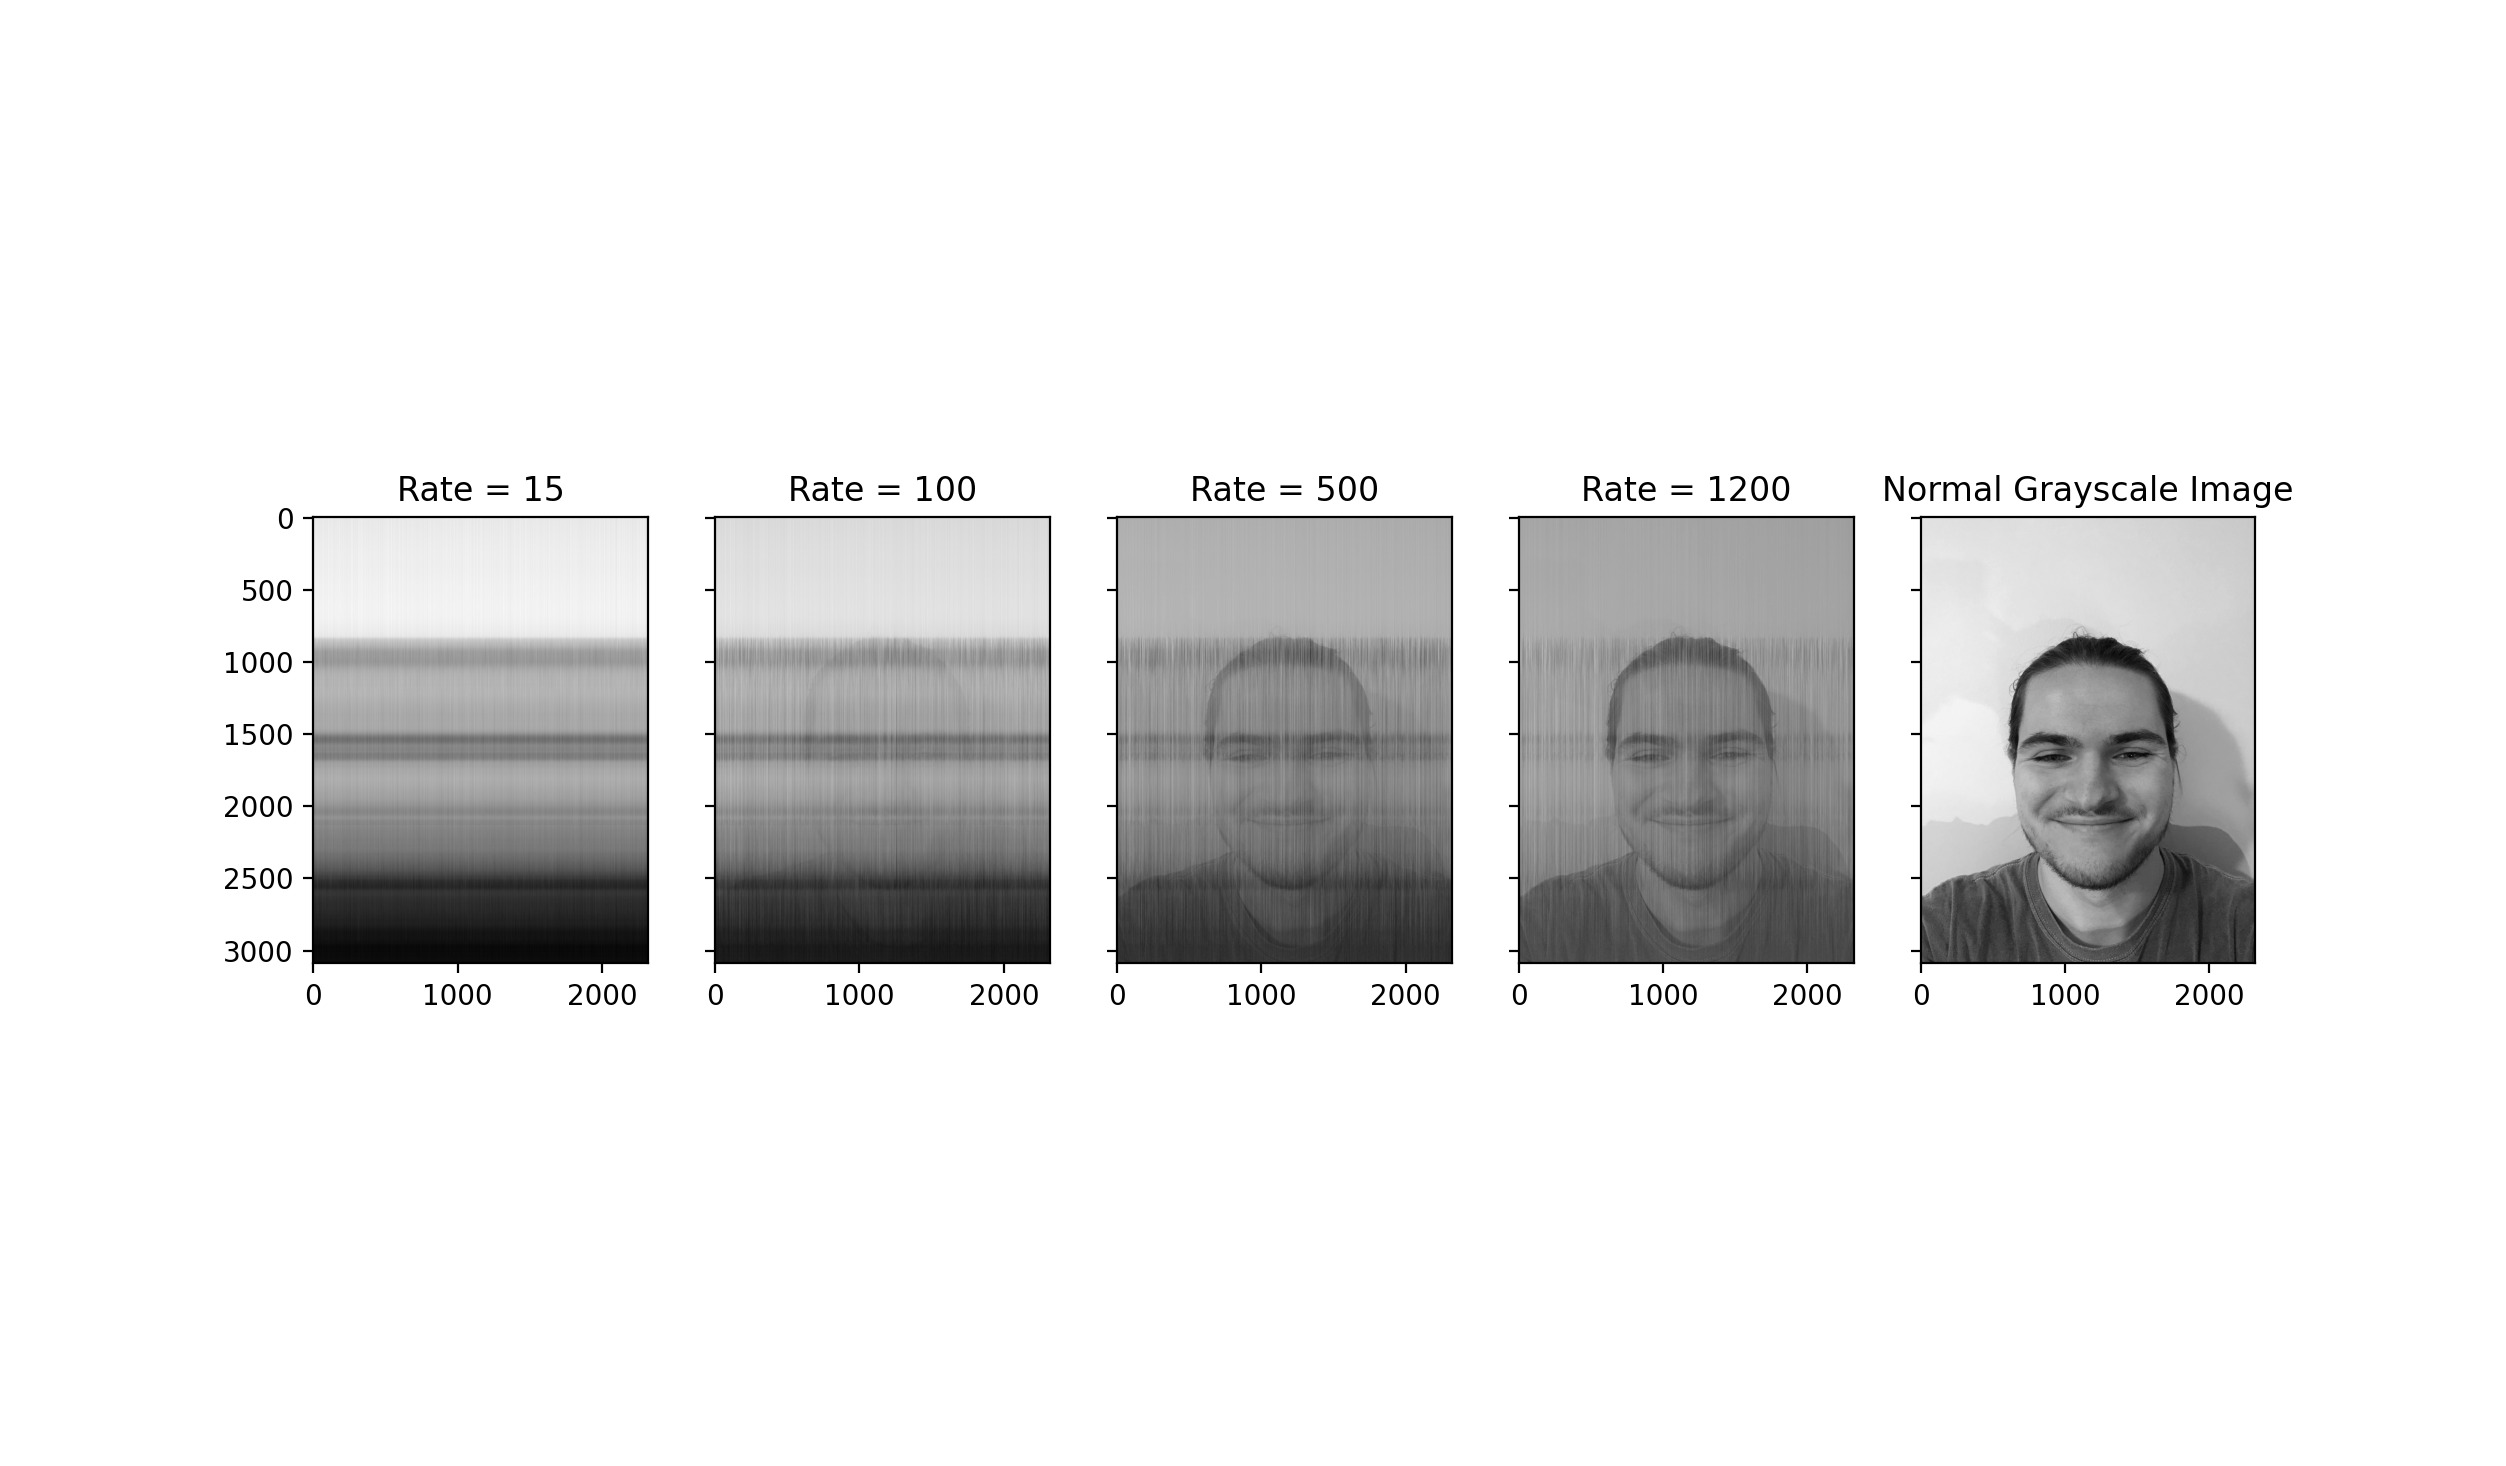

In [6]:
# Visualizing each of the images:
Image(filename = os.path.join(os.getcwd(), "svd_pics.png"))

If you would like, you can run the code below that generated the image above.

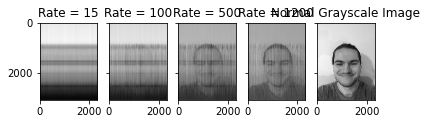

In [7]:
fig, axs = plt.subplots(1, 5, sharey = True, sharex = True)
svd15,_ = compute_SVD(selfie, 15)
svd100,_ = compute_SVD(selfie, 100)
svd500,_ = compute_SVD(selfie, 500)
svd1200,_ = compute_SVD(selfie, 1200)
svdnorm,_ = compute_SVD(selfie)

axs[0].imshow(svd15, cmap = "gray")
axs[0].set_title("Rate = 15")
axs[1].imshow(svd100, cmap = "gray")
axs[1].set_title("Rate = 100")
axs[2].imshow(svd500, cmap = "gray")
axs[2].set_title("Rate = 500")
axs[3].imshow(svd1200, cmap = "gray")
axs[3].set_title("Rate = 1200")
axs[4].imshow(svdnorm, cmap = "gray")
axs[4].set_title("Normal Grayscale Image")

plt.show()

## Conclusion
In conclusion, the SVD method for image compression seems to serve to reduce the dimensionality of the image while preserving key features. This method could be very applicable in the image processing field. My image was taken in odd lighting, so we observe some odd results with low ranks, but the method overall seems to work very well.